In [1]:
from keras.applications import VGG16
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
model = VGG16(weights='imagenet', include_top=False)

In [3]:
for ii, layer in enumerate(model.layers):
    print(ii, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [4]:
model.layers[7].output

<tf.Tensor 'block3_conv1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>

#### Note: there are 256 filters for this layer!

In [5]:
layer_name = 'block3_conv1'
filter_index = 0

In [6]:
layer_output = model.get_layer(layer_name).output

In [7]:
layer_output

<tf.Tensor 'block3_conv1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>

#### We define now the loss function for this layer (just the mean of the tensot)

In [8]:
loss = K.mean(layer_output[:, :, :, filter_index])

#### Calculate the gradient of the loss with respect the input

In [9]:
grads = K.gradients(loss, model.input)[0]

#### To help the gradient-descent process to go smoothly one normalises the gradient tensor by dividing it by its L2 norm

In [10]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

#### Now we need a way to compute the value of the loss tensor and the gradient tensor, given an input image

#### We define a Keras backend function to do this: it takes a Numpy tensor (as a list of tensors of size 1) and returns a list of two Numpy tensors: the loss value and the gradient value.

In [11]:
iterate = K.function([model.input], [loss, grads])

#### Calculate the loss with respect to a blank input image

In [12]:
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

#### Let's create a gray image with some noise

In [13]:
input_img_data = 128 + np.random.random((1, 150, 150, 3)) * 20

In [14]:
img_tensor = input_img_data/255

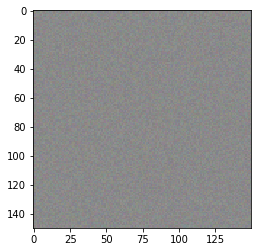

In [15]:
plt.imshow(img_tensor[0])
plt.show()

#### Loss maximization via stochastic gradient descent

In [16]:
step = 1.

for i in range(40):
    #calculate the gradient with respec the input
    loss_value, grads_value = iterate([input_img_data])
    #change the input exactly of the gradient to find the max
    input_img_data += grads_value * step

In [17]:
img = input_img_data[0]

#### the values of the image may not be integers within [0, 255]. Hence, you need to postprocess

In [18]:
def deprocess_image(x):
    
    #normalise the tensor
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    
    #convert to RGB
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [19]:
visual_filter = deprocess_image(img)

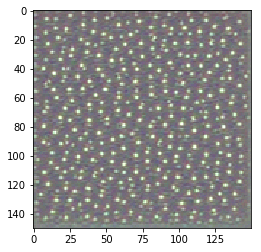

In [20]:
plt.imshow(visual_filter)

# Define a general function which does everything

In [21]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    
    return deprocess_image(img)

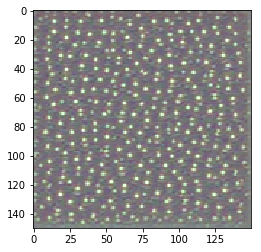

In [22]:
plt.imshow(generate_pattern('block3_conv1', 0))

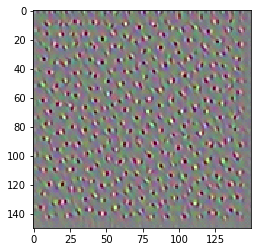

In [23]:
plt.imshow(generate_pattern('block3_conv1', 255))

# Generating a grid of all filter response patterns in a layer

#### (We only look at the first 64 filters in each layer, and only look at the first layer of each convolution block)

In [24]:
layer_name = 'block1_conv1'

#arrange the outputs on an 8 × 8 grid of 64 × 64 filter patterns, with some black margins between each filter pattern
size = 64
margin = 5

#### Empty (black) image to store results

In [25]:
#Note: important to transform in uint8, otherwise later "results" will be float!!!!
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3)).astype('uint8')

#### Generate grid

In [26]:
for i in range(8): #rows
    for j in range(8): #columns
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img #.astype('uint8')

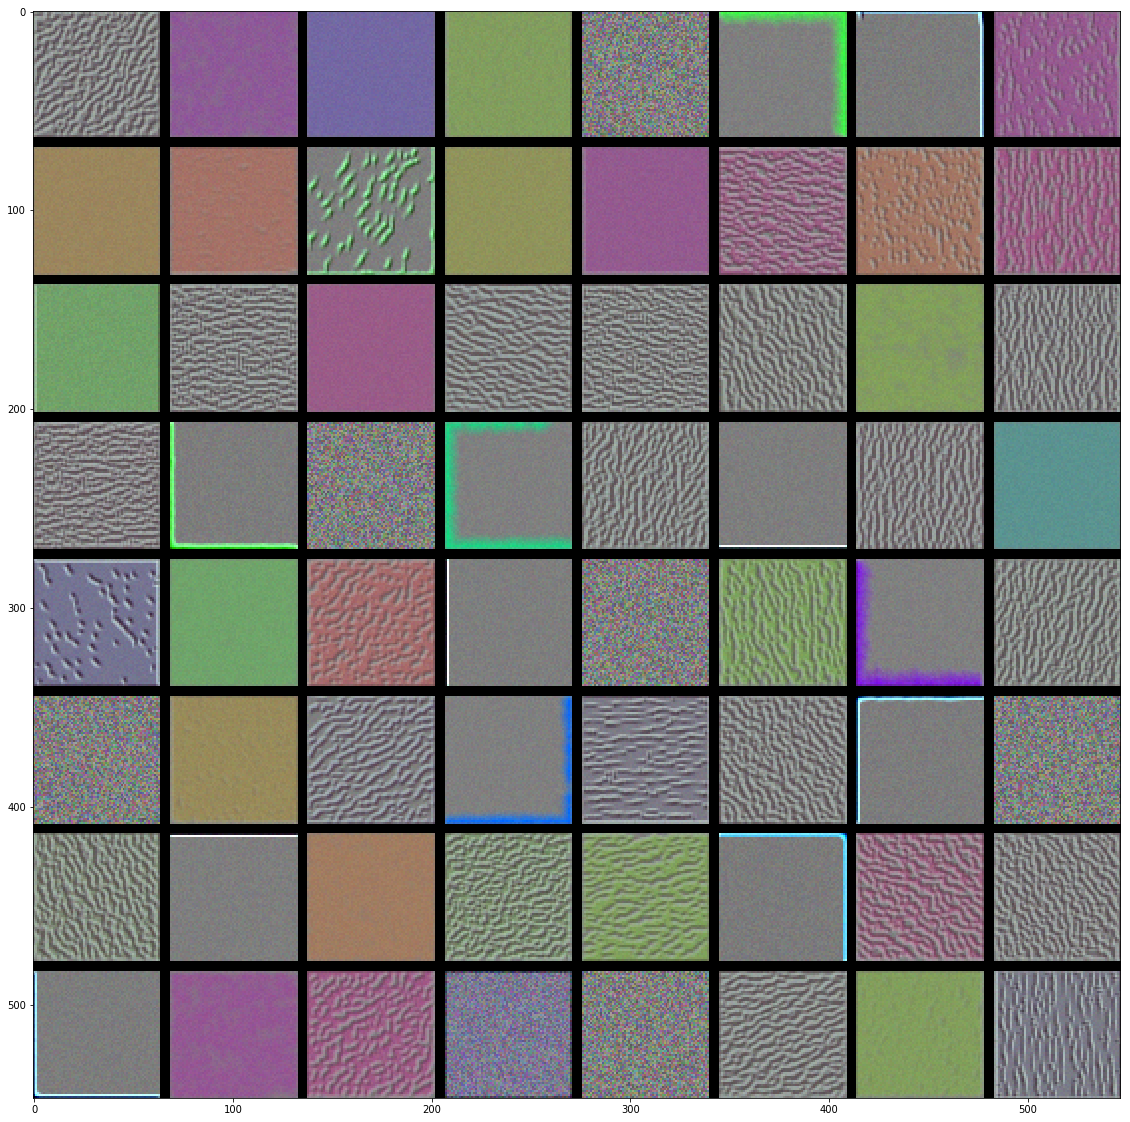

In [27]:
plt.figure(figsize=(20, 20))  
plt.imshow(results)